Import all necessary packages and functions

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from scipy.sparse import load_npz
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve



In [7]:
# Load data
X_train = load_npz("X_train_sparse.npz")
X_test = load_npz("X_test_sparse.npz")
y_train = np.load("y_train.npy")
y_test = np.load("y_test.npy")

In [8]:
# Train Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)
lr_probs = lr_model.predict_proba(X_test)[:, 1]

# Train Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
nb_preds = nb_model.predict(X_test)
nb_probs = nb_model.predict_proba(X_test)[:, 1]

We will be performing error-based model ensemble.

In [9]:
# 2. Create empty ensemble prediction array
ensemble_preds = []
ensemble_probs = []

for i in range(len(y_test)):
    if lr_preds[i] == nb_preds[i]:
        # Both agree
        prob = (lr_probs[i] + nb_probs[i]) / 2
    elif lr_preds[i] == y_test[i] and nb_preds[i] != y_test[i]:
        prob = lr_probs[i]
    elif nb_preds[i] == y_test[i] and lr_preds[i] != y_test[i]:
        prob = nb_probs[i]
    else:
        # Both wrong: default to baseline model LR
        prob = lr_probs[i]

    pred = 1 if prob >= 0.5 else 0

    ensemble_probs.append(prob)
    ensemble_preds.append(pred)

ensemble_probs = np.array(ensemble_probs)
ensemble_preds = np.array(ensemble_preds)


=== Log Regression and Naive Bayes Model Ensemble Performance ===
Accuracy:  0.9886
Precision: 0.9859
Recall:    0.9901
F1 Score:  0.9880
AUC:       0.9975


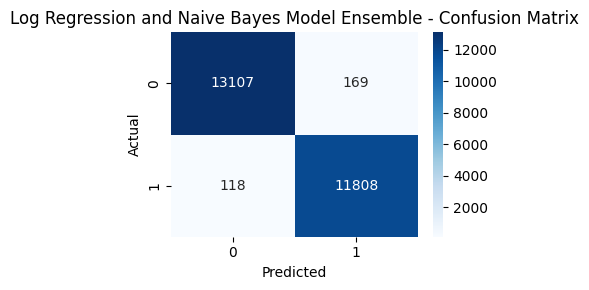

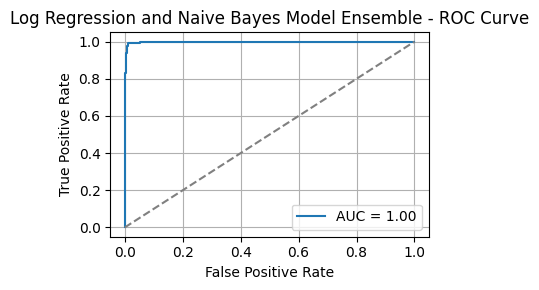

In [10]:
acc = accuracy_score(y_test, ensemble_preds)
prec = precision_score(y_test, ensemble_preds)
rec = recall_score(y_test, ensemble_preds)
f1 = f1_score(y_test, ensemble_preds)
fpr, tpr, _ = roc_curve(y_test, ensemble_probs)
roc_auc = auc(fpr, tpr)
cm = confusion_matrix(y_test, ensemble_preds)

print(f"\n=== {"Log Regression and Naive Bayes Model Ensemble Performance"} ===")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AUC:       {roc_auc:.4f}")

# Confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f"{"Log Regression and Naive Bayes Model Ensemble"} - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ROC Curve
plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"{"Log Regression and Naive Bayes Model Ensemble"} - ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()